# Extensive Example

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import hostphot
from hostphot.cutouts import download_images
from hostphot.coadd import coadd_images
from hostphot.image_masking import create_mask
from hostphot.utils import plot_fits, update_axislabels, get_survey_filters
import hostphot.local_photometry as lp
import hostphot.global_photometry as gp

print('HostPhot version:', hostphot.__version__)

HostPhot version: 2.6.0


In this example, we will be using [SN 2002fk](https://www.wis-tns.org/object/2002fk) to show some of the features included in HostPhot.

In [2]:
name = '2002fk'
ra, dec = 50.52379, -15.40089
host_ra, host_dec = 50.527333, -15.400056
z = 0.0075

## Download Image Cutouts

As always, the first step is to download the image cutouts, which we will center at the position of the host galaxy. We will use ``overwrite=True`` to overwrite any previously downloaded images.

In [3]:
surveys = ['DES', 'PS1', 'SDSS', 'GALEX', '2MASS', 'unWISE']
for survey in surveys:
    download_images(name, host_ra, host_dec, 
                    survey=survey, overwrite=True)

### Plot Images

Let's have a quick look of how the images look...

In [4]:
fits_files = []
for survey in surveys:
    survey_files = glob.glob(f'images/{name}/{survey}*')
    for file in survey_files:
        if os.path.basename(file).startswith(survey) and file.endswith('.fits'):
            fits_files.append(file)
            
fits_files = list(np.sort(fits_files))

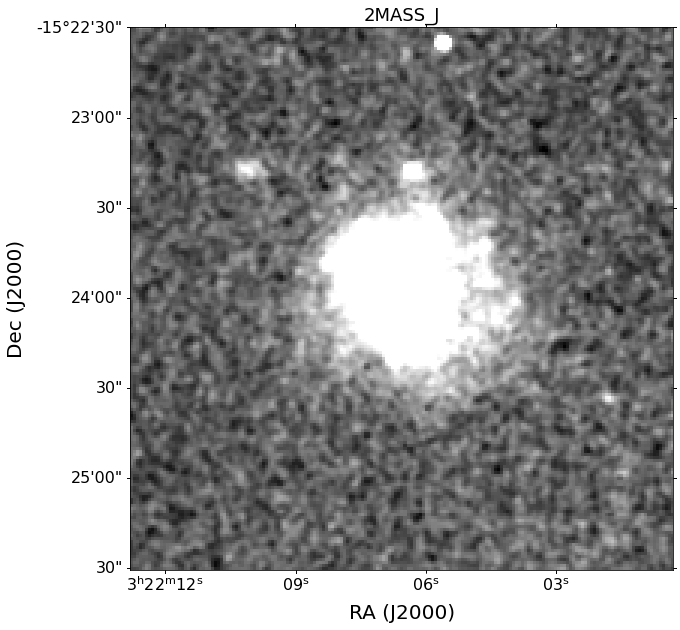

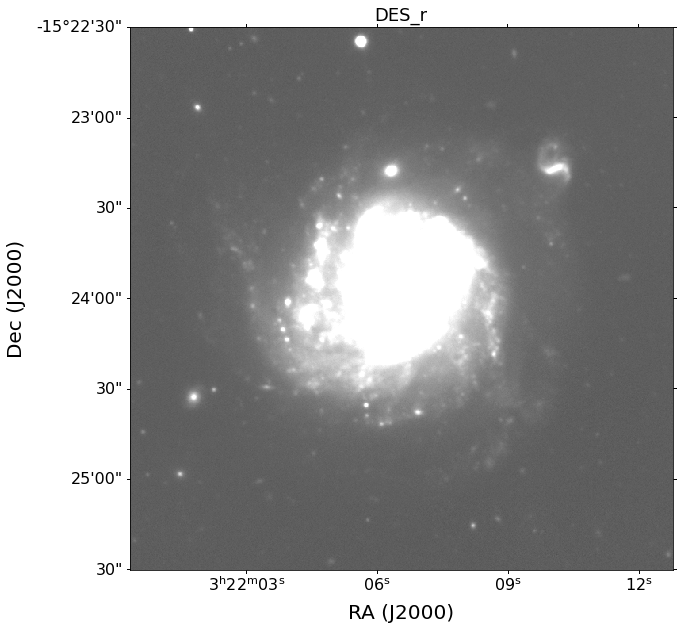

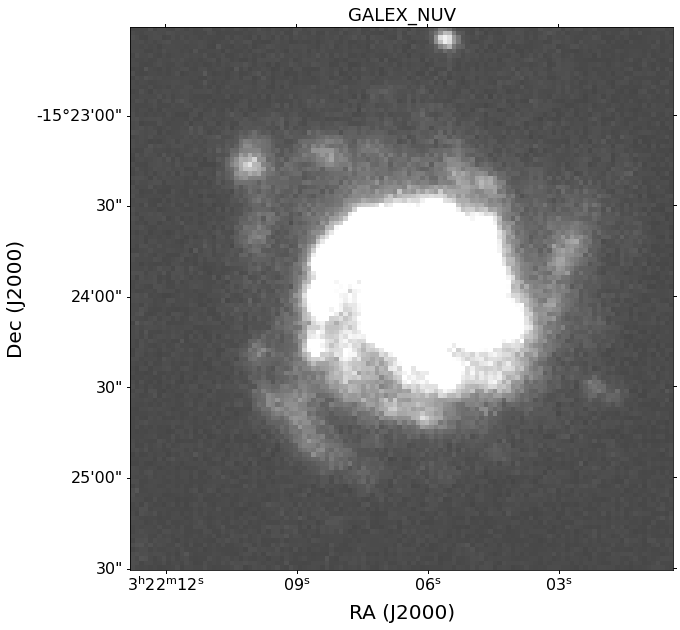

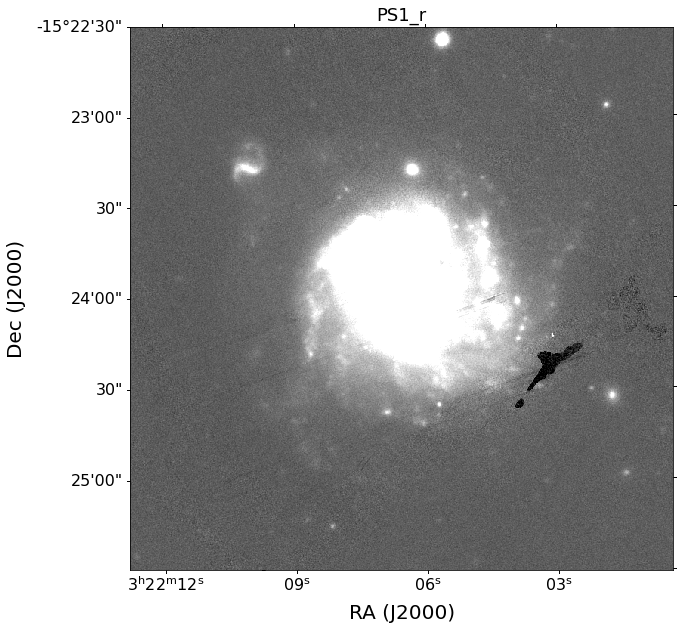

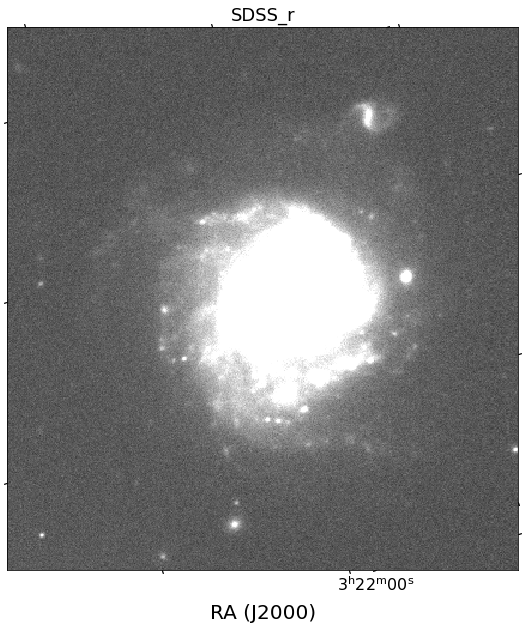

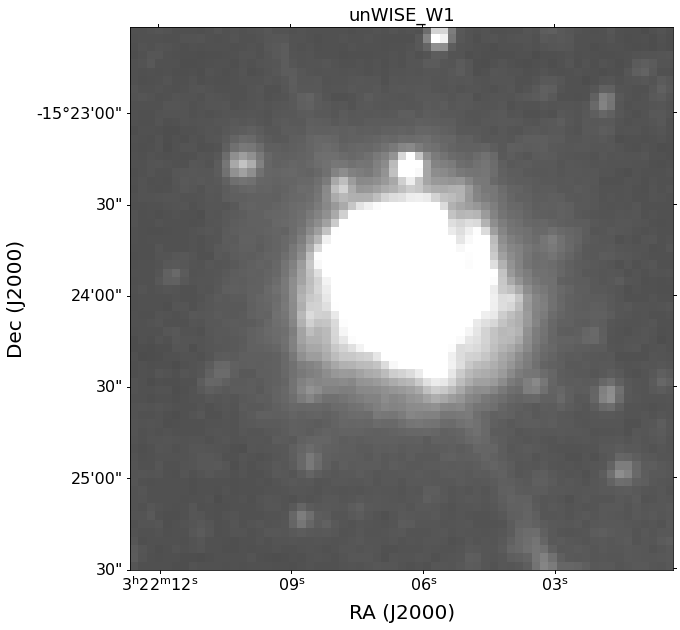

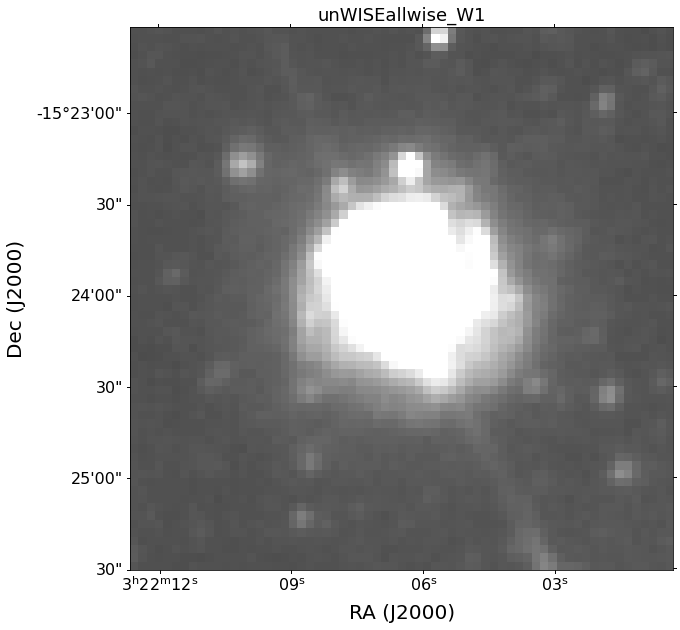

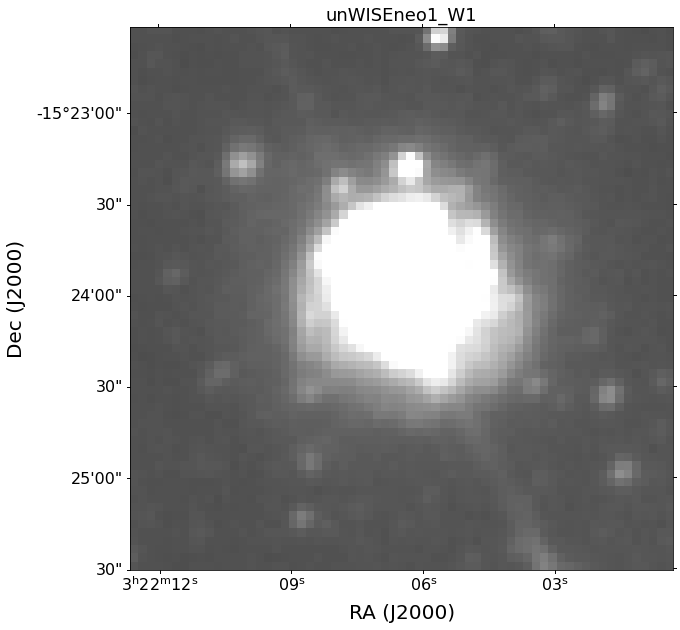

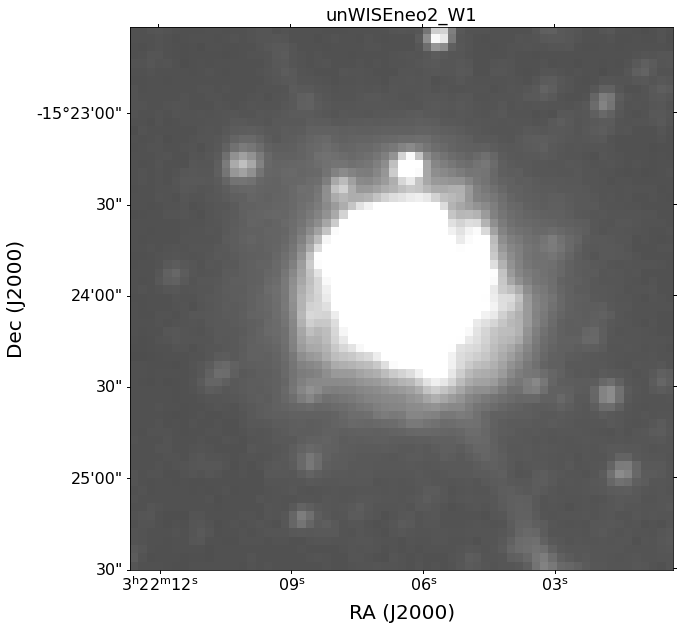

In [5]:
for file in fits_files:
    # use one band per survey as there are many images
    if '_r.fits' in file or '_NUV.fits' in file or '_J.fits' in file or '_W1.fits' in file:
        plot_fits(file)

There are a few things to notice here. The first is that not all the surveys have the same orientation. This is not really a problem as HostPhot deals with this using the WCS from the headers of the images. Visually, it might be annoying, though. The second thig is that some images might include some artifacts, as is the case for PS1 in this example. Lastly, the SDSS images do not show the Declination axis label, which is annoying, but not essential.

## Coadds

We can now create coadds for the different surveys to use them as a reference for the rest of the filters. For the optical surveys, we will use `riz`, for GALEX we will use `FUV` and `NUV`, for 2MASS `J` and `H`, and for unWISE `W1` and `W2`. In principle, we could use all the available filters, although the ones not used here do not have high signal-to-noise compared to the rest.

In [6]:
coadd_dict = {'GALEX':['NUV', 'FUV'],
              'PS1':'riz',
              'DES':'riz',
              'SDSS':'riz',
              '2MASS':['J', 'H'],
              'unWISE':['W1', 'W2']
             }
for survey, coadd_filters in coadd_dict.items():
    coadd_images(name, filters=coadd_filters, survey=survey)

## Masking

We can now create the masks for each survey using their respective coadd images.

In [7]:
for survey, coadd_filters in coadd_dict.items():
    filters = get_survey_filters(survey)
    coadd_mask_params = create_mask(name, host_ra, host_dec,
                                    filt=coadd_filters, 
                                    survey=survey,
                                    extract_params=True)

    for filt in filters:
        create_mask(name, host_ra, host_dec, 
                    filt, survey=survey,
                    common_params=coadd_mask_params)

### Plot masks

Let's check the masks

In [8]:
masked_files = []
for survey in surveys:
    survey_files = glob.glob(f'images/{name}/masked_{survey}*')
    for file in survey_files:
        if survey in file and file.endswith('.fits'):
            masked_files.append(file)
            
masked_files = list(np.sort(masked_files))

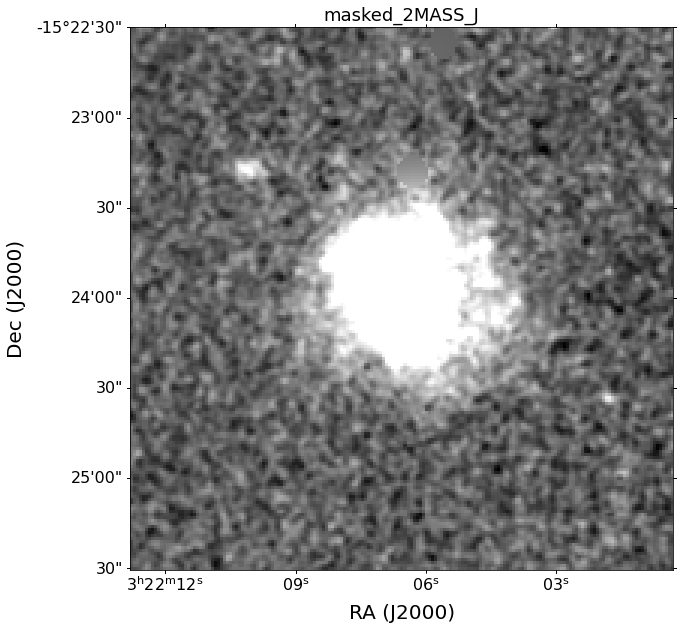

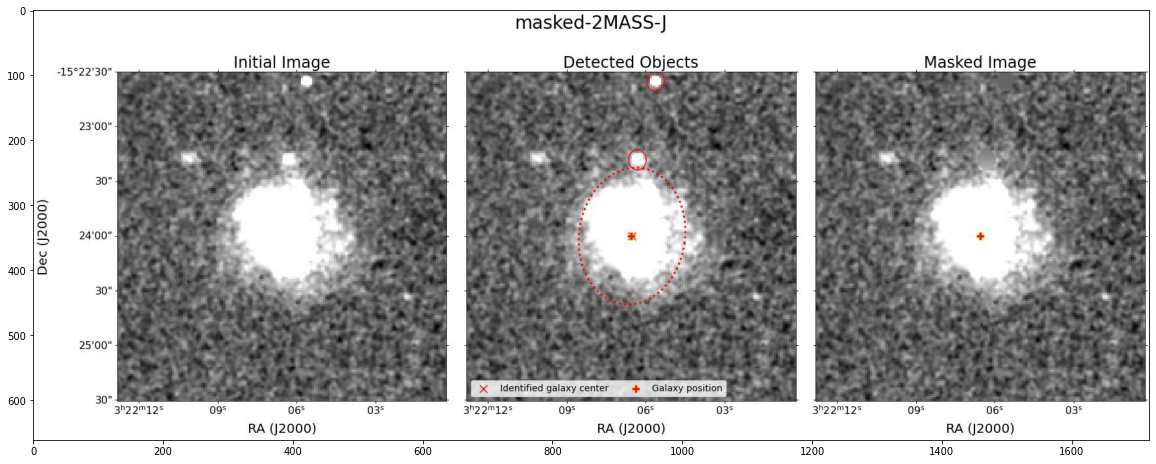

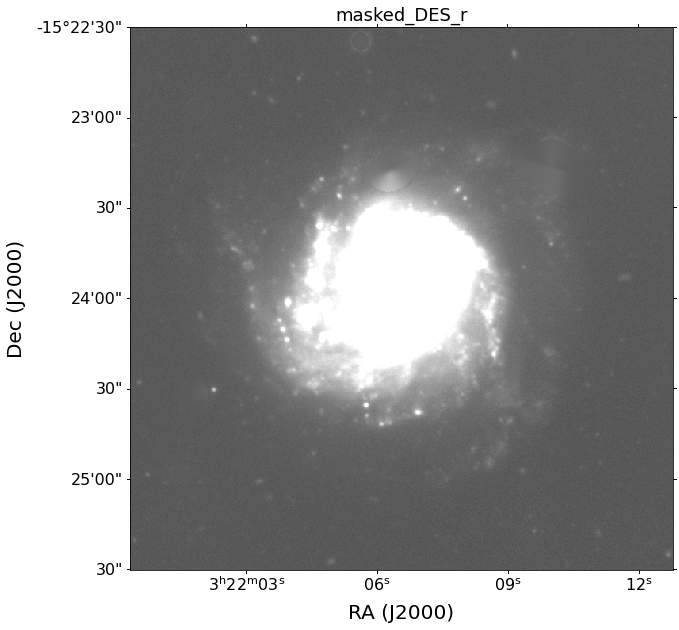

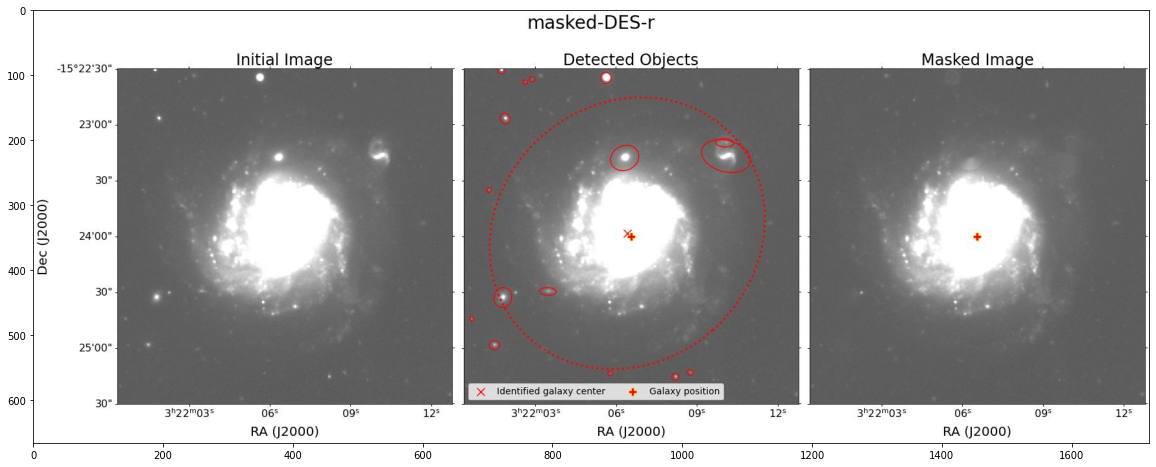

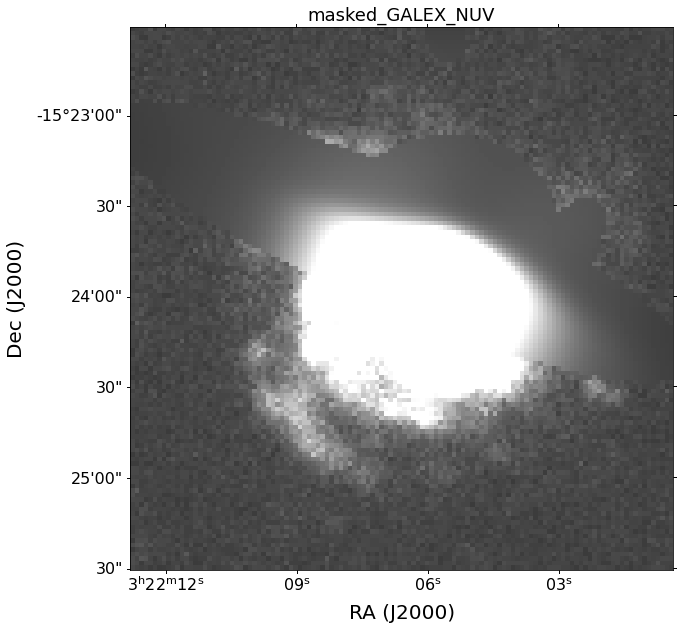

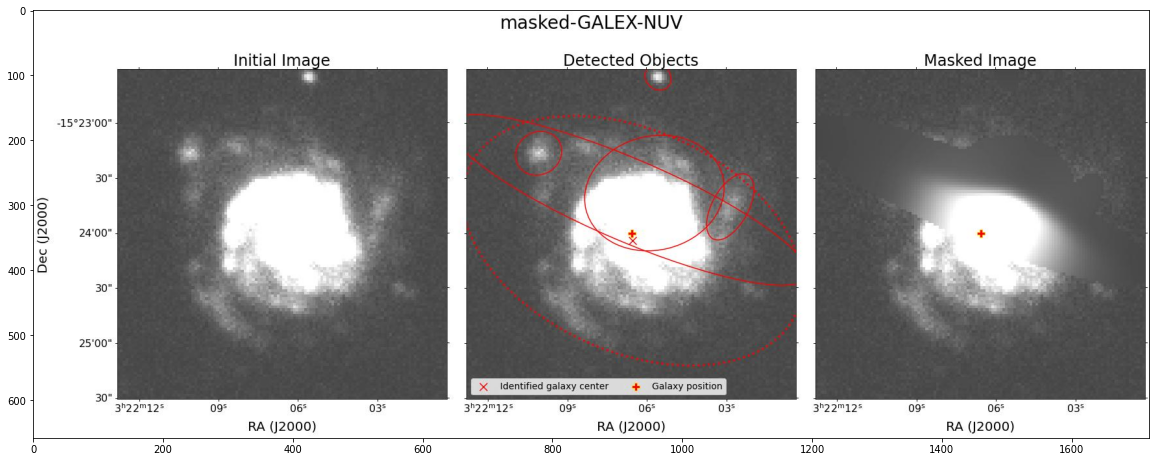

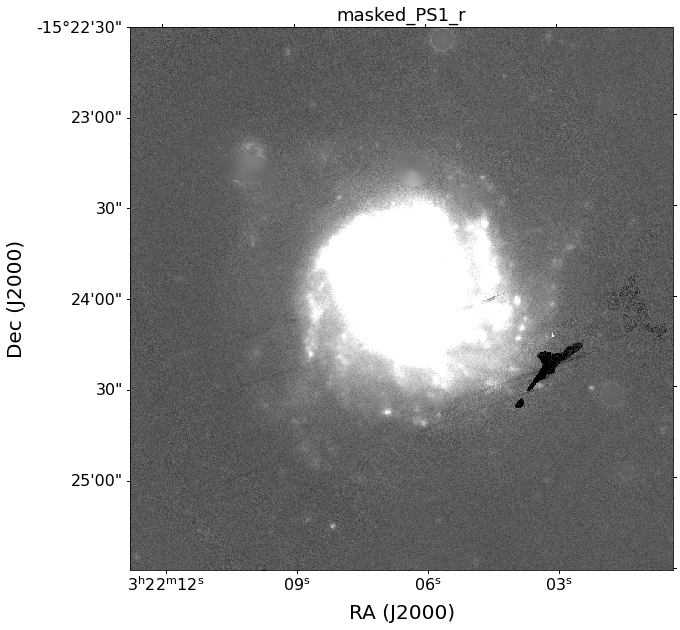

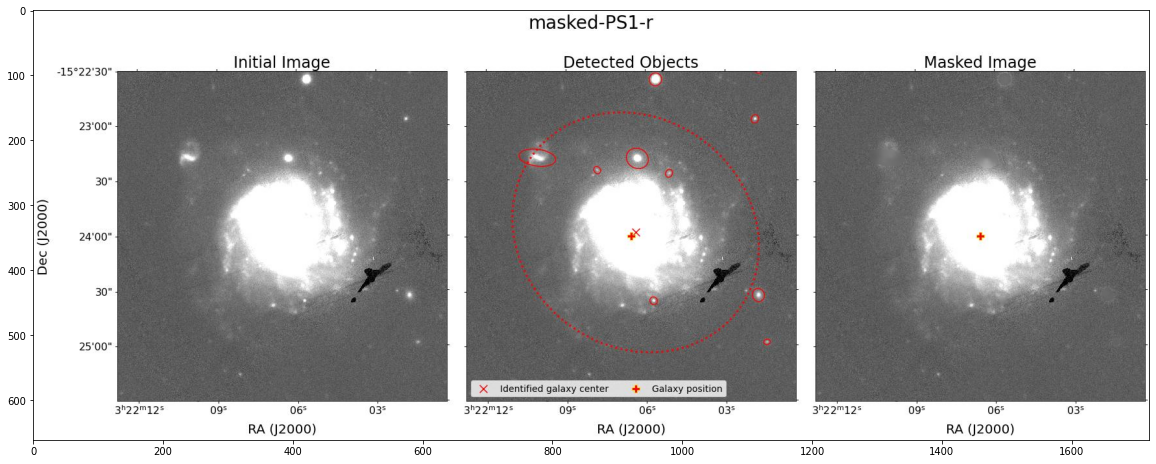

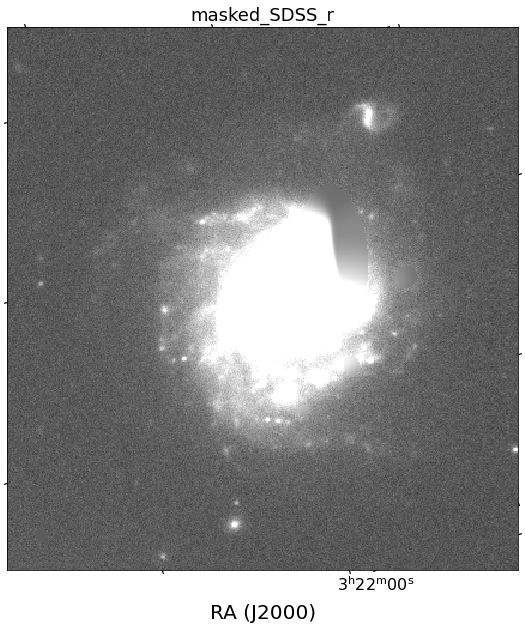

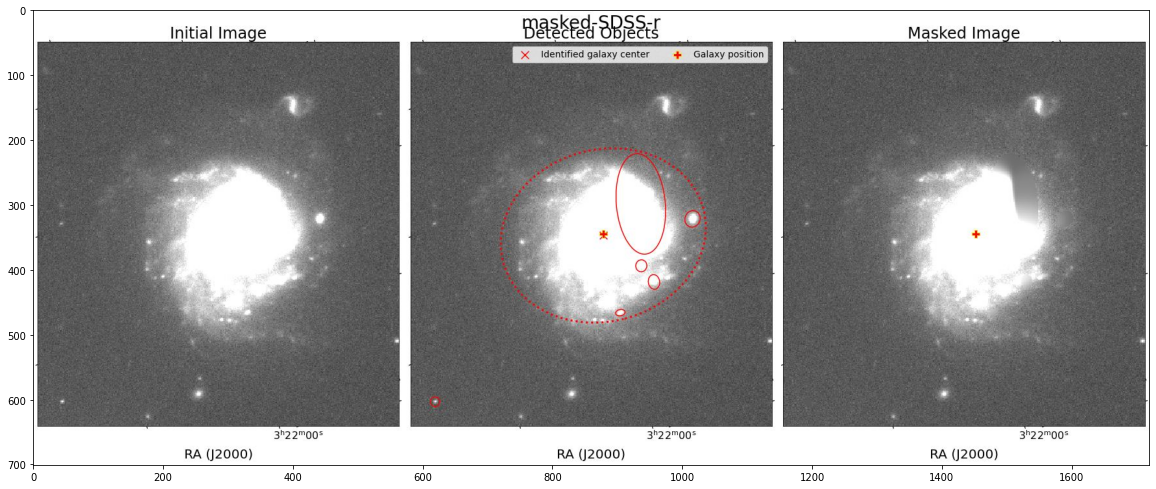

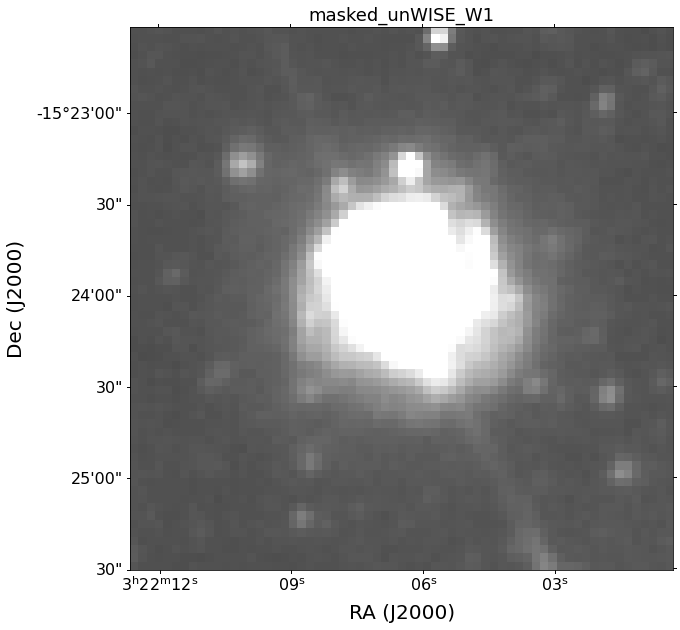

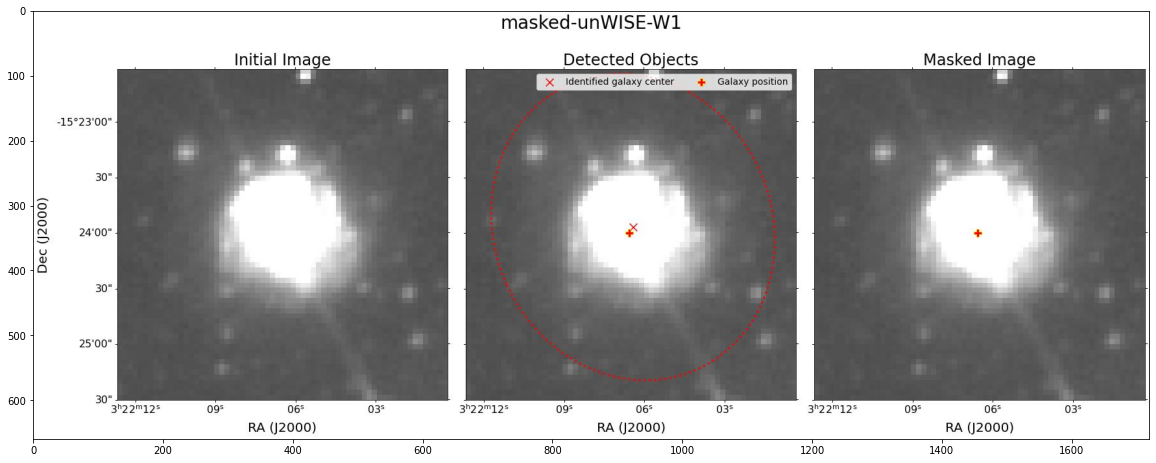

In [9]:
for file in masked_files:
    if '_r.fits' in file or '_NUV.fits' in file or '_J.fits' in file or '_W1.fits' in file:
        plot_fits(file)
        
        jpg_file = file.replace('.fits', '.jpg')
        plt.figure(figsize=(20, 12))
        img = mpimg.imread(jpg_file)
        imgplot = plt.imshow(img)
        plt.show()

Some of the masks look good, but others look terrible. We play around with some of the parameters in `create_mask` function. However, in this case, we will use a different approach. 

In most cases, optical surveys have much better resolution than surveys at other wavelengths. Therefore, we can use one of the optical surveys as a reference for all the others. In this case, we will use PS1.

## Masking - revised

First, we need to collect the masking parameters from the PS1 coadd image. Note that we will set `crossmatch=True` to avoid masking parts of the galaxy.

In [10]:
survey = 'PS1'
filters = get_survey_filters(survey)
coadd_filters = coadd_dict[survey]
coadd_mask_params = create_mask(name, host_ra, host_dec,
                                filt=coadd_filters, survey=survey,
                                extract_params=True, crossmatch=True)

INFO: Query finished. [astroquery.utils.tap.core]


Note that the mak parameters are saved into a pickle file by default so they can be used at a later time.

Now, we can apply the mask to all the other surveys. Remember that HostPhot deals with different surveys having different orientations and also different pixel scales. We can also change the size of the convolution Gaussian kernel to try to adapt to the different pixel scales (this is done by changing `sigma`). Unfortunately, there is no smarter way to automate this, at least for now (let me know if you find a way!).

In [11]:
# the optical surveys have relative similar resolution
sigma_dict = {survey:8 if survey!='GALEX' else 4 for survey in surveys}

for survey, coadd_filters in coadd_dict.items():
    filters = get_survey_filters(survey)
    for filt in filters:
        create_mask(name, host_ra, host_dec, 
                    filt, survey=survey,
                    common_params=coadd_mask_params, 
                    sigma=sigma_dict[survey])

### Plot masks - revised

Let's see how the new masks look!

In [12]:
masked_files = []
for survey in surveys:
    survey_files = glob.glob(f'images/{name}/masked_{survey}*')
    for file in survey_files:
        if survey in file and file.endswith('.fits'):
            masked_files.append(file)
            
masked_files = list(np.sort(masked_files))

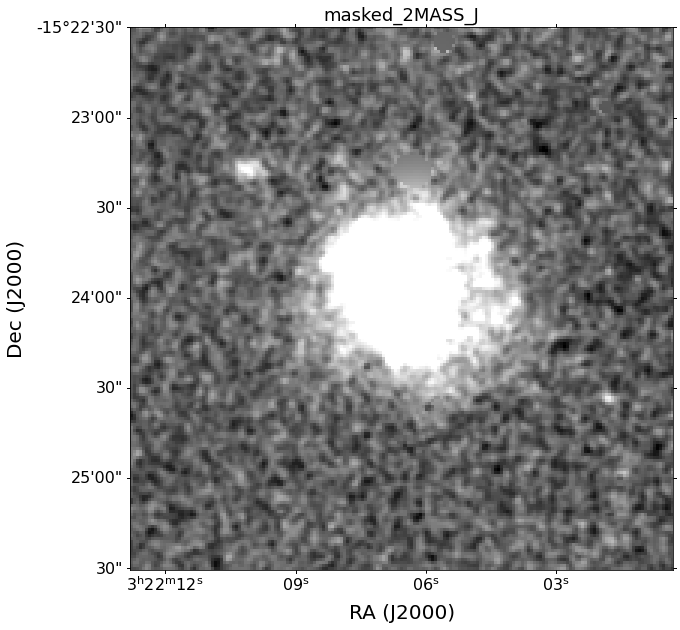

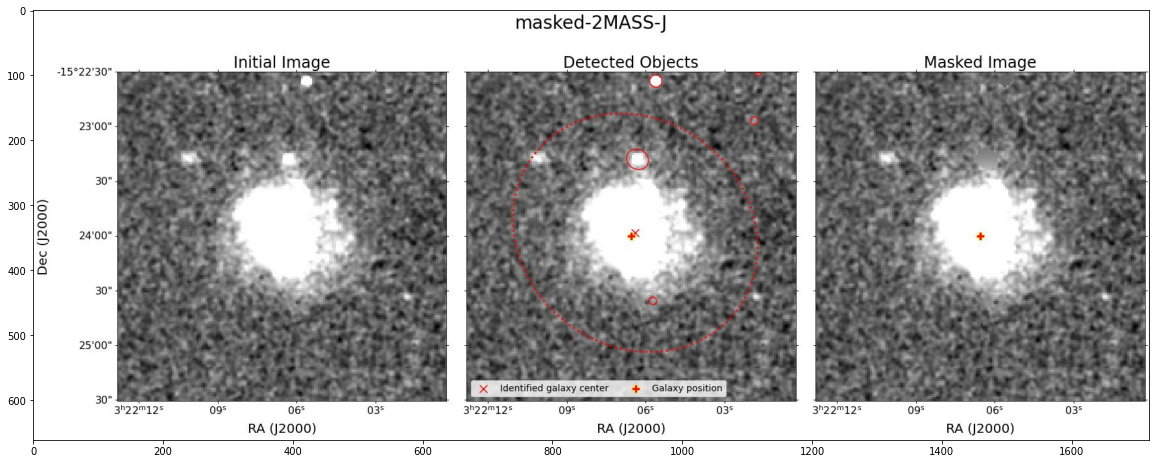

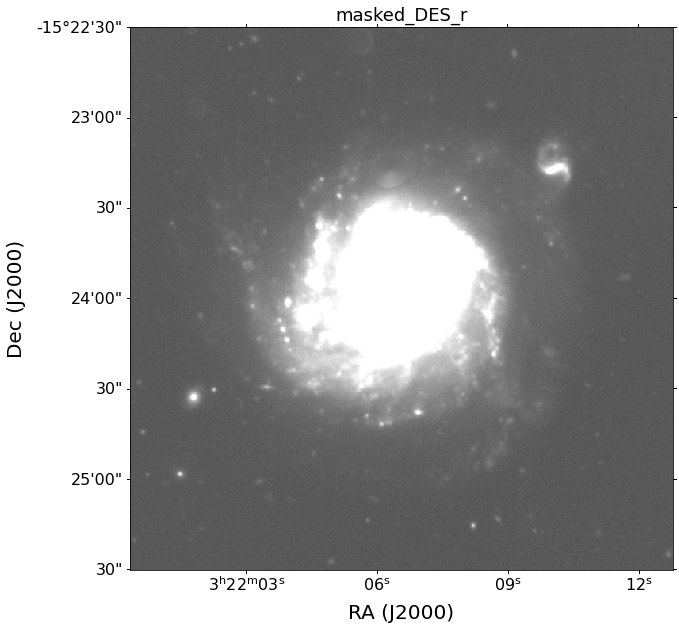

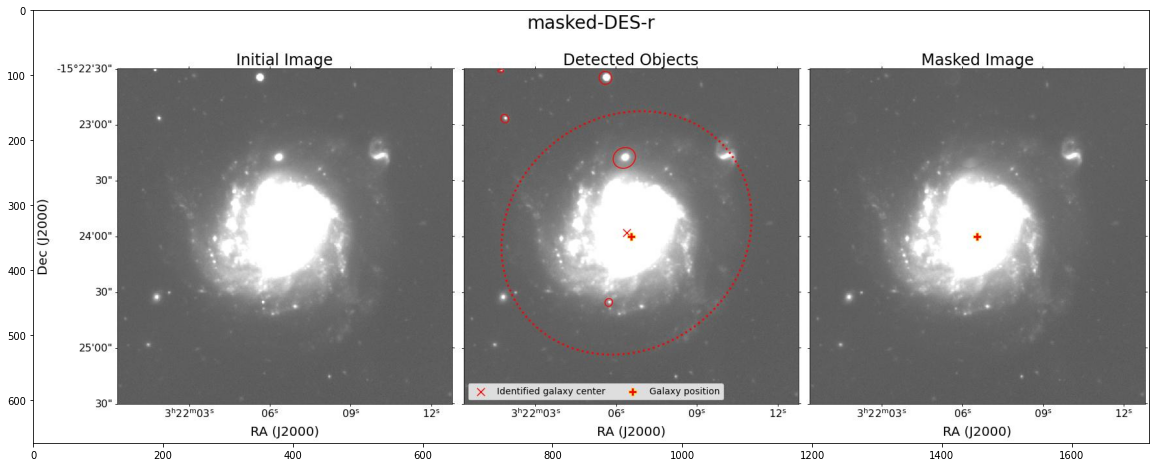

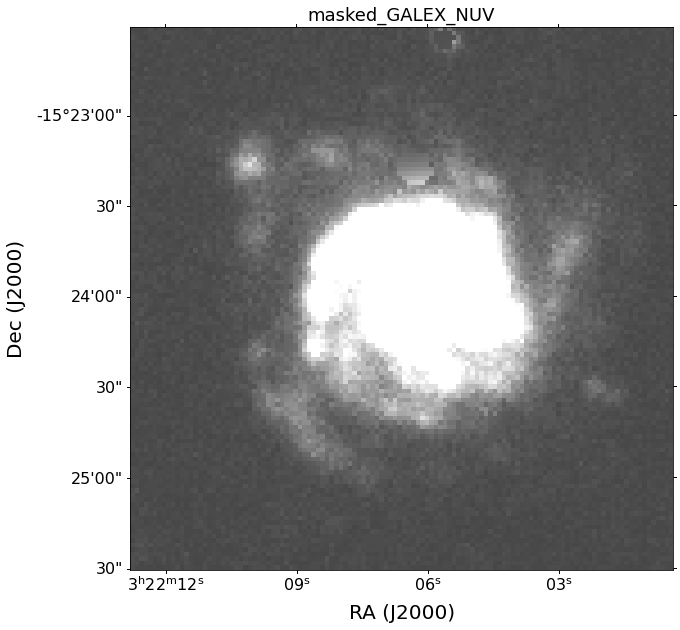

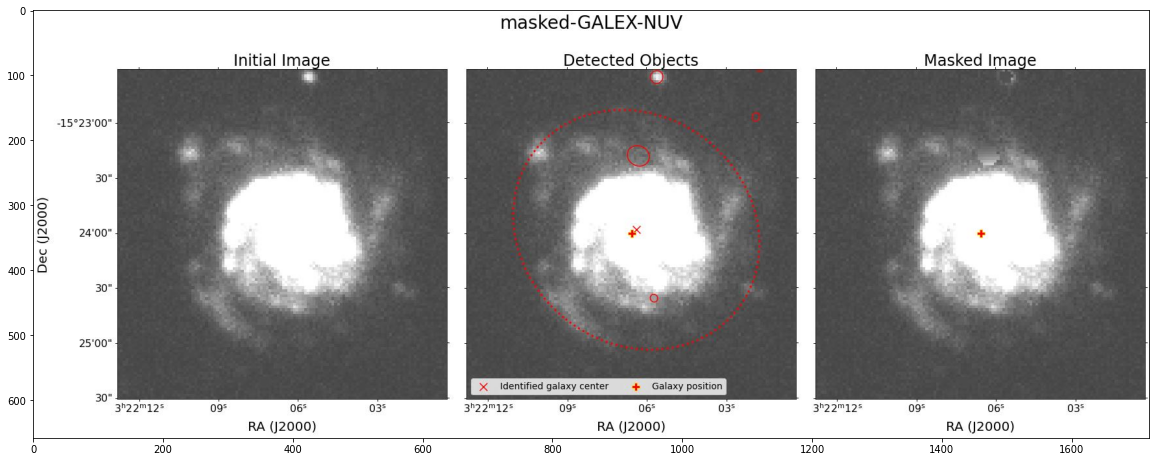

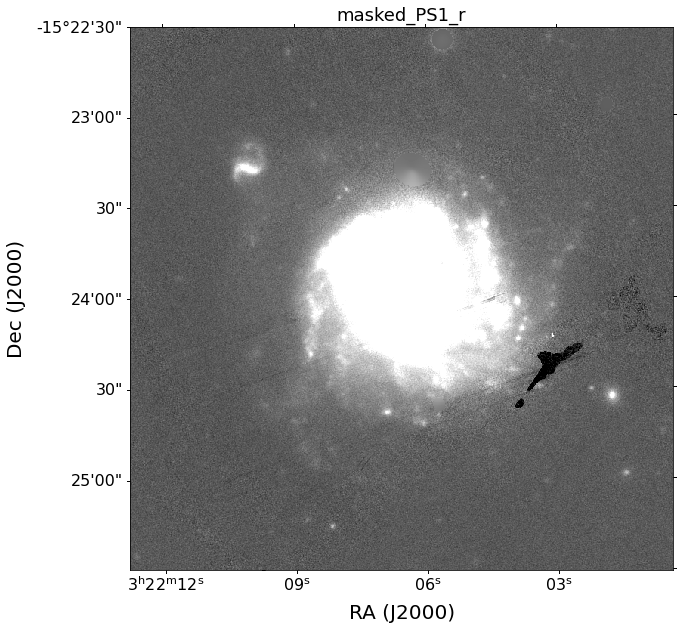

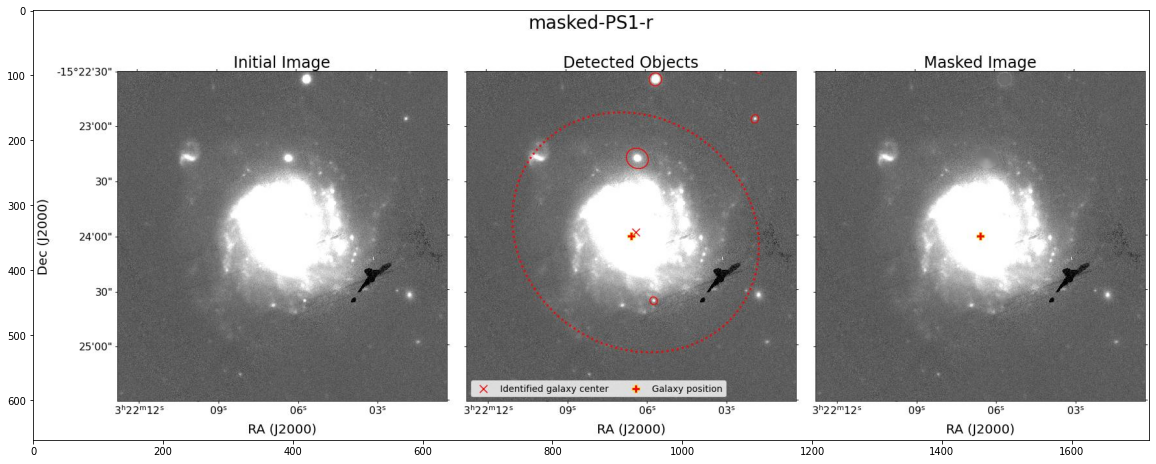

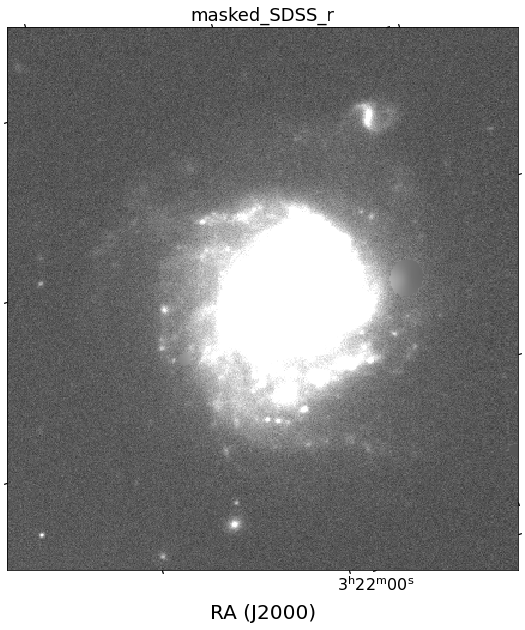

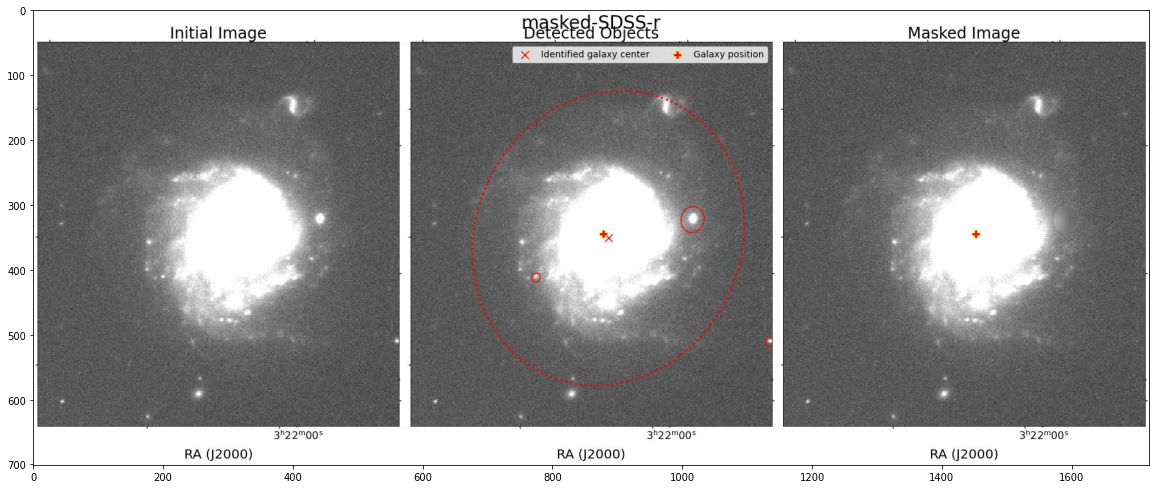

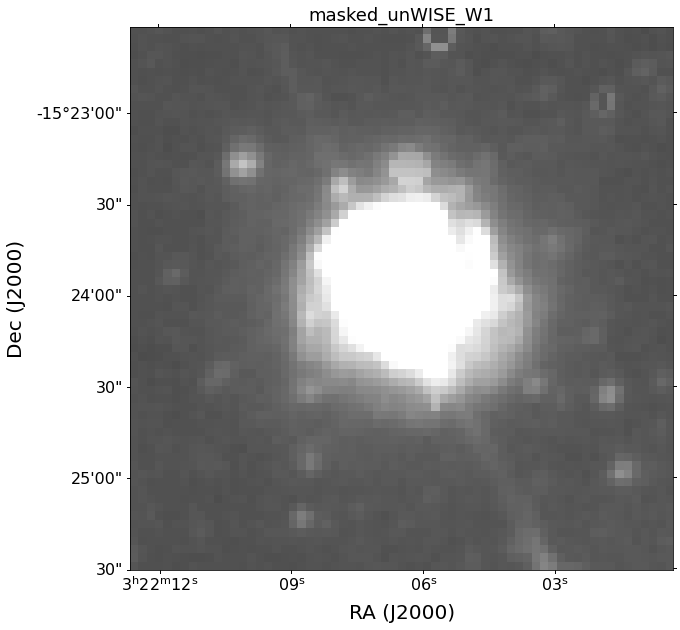

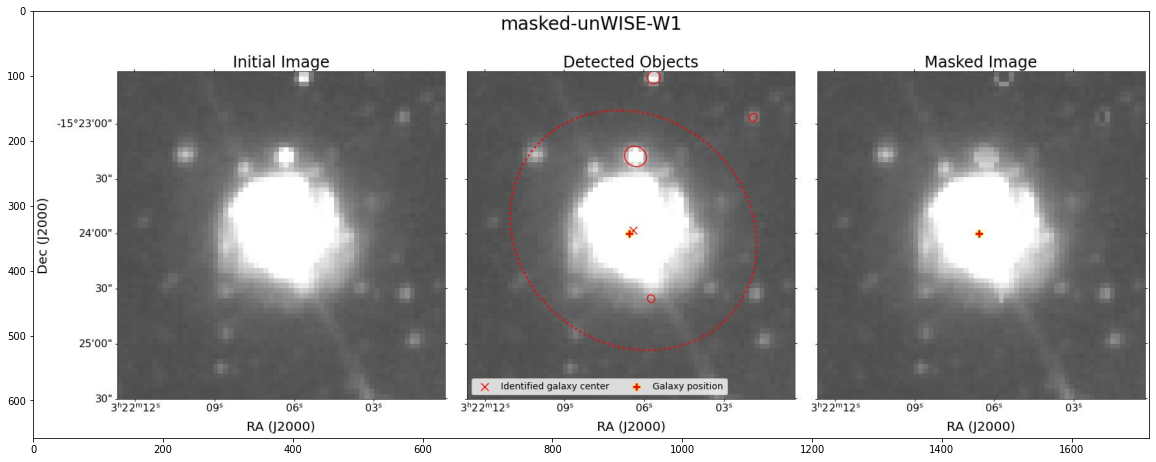

In [13]:
for file in masked_files:
    if '_r.fits' in file or '_NUV.fits' in file or '_J.fits' in file or '_W1.fits' in file:
        plot_fits(file)
        
        jpg_file = file.replace('.fits', '.jpg')
        plt.figure(figsize=(20, 12))
        img = mpimg.imread(jpg_file)
        imgplot = plt.imshow(img)
        plt.show()

The masks look much better now! There is just that background galaxy which was not masked out, but will probably not affect the photometry as it is relatively far from the galaxy of interest.

## Photometry

Now that the images have been "cleaned", we can start getting the photometry.

### Local Photometry

This is simple and there is not much to say. We can just use all the different aperture sizes we want. We will set `raise_exception=True` to raise an error in case the photometry fails for whatever reason as it would otherwise return NaN values, and we don't want that in this case.

In [ ]:
ap_radii = [3, 4]  # aperture radii in units of kpc

for survey in surveys:
    # the results will be saved in different files 
    # for the different surveys
    lp.multi_band_phot(name, ra, dec, z,
                       survey=survey, ap_radii=ap_radii,
                       use_mask=True, correct_extinction=True,
                       save_plots=True, save_results=True, 
                       raise_exception=True)

We can plot one of the images to see how the aperture looks.

In [ ]:
plt.figure(figsize=(20, 12))
img = mpimg.imread(f'images/{name}/local_PS1_r_3kpc.jpg')
imgplot = plt.imshow(img)
plt.show()

Great! We are finished with the local photometry.

### Global Photometry

This one can be a bit more tricky, specially for nearby galaxies like this one.

Let's optimize the aperture radius until the change in flux is less than 0.1% (`eps=0.001`)

In [ ]:
eps = 0.001
coadd_dict = {'GALEX':['NUV', 'FUV'],
              'PS1':'riz',
              'DES':'riz',
              'SDSS':'riz',
              '2MASS':['J', 'H'],
              'unWISE':['W1', 'W2']
             }
for survey in surveys:
    results = gp.multi_band_phot(name, host_ra, host_dec,
                            survey=survey, ra=ra, dec=dec,
                            use_mask=True, correct_extinction=True,
                            common_aperture=True, coadd_filters=coadd_dict[survey],
                            save_plots=True, save_results=True, eps=eps,
                            raise_exception=True)

Let's see how the global apertures look.

In [ ]:
bands_dict = {'GALEX':'NUV',
              'PS1':'r',
              'DES':'r',
              'SDSS':'r',
              '2MASS':'J',
              'unWISE':'W1',
             }
for survey in surveys:
    plt.figure(figsize=(20, 12))
    jpg_file = os.path.join('images', name, 
                 f'global_{survey}_{bands_dict[survey]}.jpg')
    img = mpimg.imread(jpg_file)
    imgplot = plt.imshow(img)
    plt.show()

They look good, except for the GALEX image, where it seems to have picked up the background galaxy. We could have a different `eps` value for each survey, but we can also use the same aperture for all of them, which is what we will do. Also note that although the aperture size is larger than the GALEX image, it doesn't affect the calculation of the magnitude, at least in this case that the entire galaxy fits insdie the image cutout.

### Global Photometry - revised

We can extract the aperture parameters of the PS1 coadd image using the `extract_kronparams` function.

In [ ]:
survey = 'PS1'
coadd_filters = 'riz'
eps = 0.001

aperture_params = gp.extract_kronparams(name, host_ra, host_dec, 
                                        coadd_filters, survey, 
                                        ra=ra, dec=dec, use_mask=True, 
                                        optimize_kronrad=True, eps=eps, 
                                        save_plots=True, 
                                        save_aperture_params=True)

Note that `save_aperture_params=True` allows us to save these parameters to be used at a later time and they can be used as common parameters for ALL the images.

In [ ]:
coadd_dict = {'GALEX':['NUV', 'FUV'],
              'PS1':'riz',
              'DES':'riz',
              'SDSS':'riz',
              '2MASS':['J', 'H'],
              'unWISE':['W1', 'W2']
             }
for survey in surveys:
    gp.multi_band_phot(name, host_ra, host_dec,
                       survey=survey, ra=ra, dec=dec,
                       use_mask=True, correct_extinction=True,
                       aperture_params=aperture_params,
                       save_plots=True, save_results=True,
                       raise_exception=True)

We can ignore the warnings as HostPhot is computing the aperture, but these are overwritten with the given aperture parameters. Let's see the results.

In [ ]:
bands_dict = {'GALEX':'NUV',
              'PS1':'r',
              'DES':'r',
              'SDSS':'r',
              '2MASS':'J',
              'unWISE':'W1',
             }
for survey in surveys:
    plt.figure(figsize=(20, 12))
    jpg_file = os.path.join('images', name, 
                 f'global_{survey}_{bands_dict[survey]}.jpg')
    img = mpimg.imread(jpg_file)
    imgplot = plt.imshow(img)
    plt.show()

Looks great! The user can decide if it is better to use the same aperture parameters for all the images or not.